In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import re

In [ ]:
# Paths
audio_dir = "/content/drive/MyDrive/ddp/ALL_gunshot"
output_dir = "/content/drive/MyDrive/ddp/spectrograms"
metadata_path = "/content/drive/MyDrive/ddp/gunshot-spectrogram-metadata.csv"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata
metadata_df = pd.read_csv(metadata_path)


In [ ]:
print(metadata_df["gunshot_location_in_seconds"].head(10))

0                                         [1.72269841]
1                                         [1.67290249]
2                   [1.61977324 3.50795918 5.42746032]
3                   [1.75       1.98768707 2.26022676]
4                   [1.75       2.61845805 3.06664399]
5    [1.50206349 1.75       1.95494331 2.15668934 2...
6                                               [1.75]
7                                               [1.75]
8                                         [1.61907029]
9                   [1.62088435 3.31027211 5.11040816]
Name: gunshot_location_in_seconds, dtype: object


In [ ]:
# Function to clean and convert gunshot location strings to lists
def fix_list_format(gunshot_string):
    if isinstance(gunshot_string, str):
        gunshot_string = gunshot_string.strip("[], ")  # Remove leading/trailing brackets, spaces, and commas
        gunshot_string = re.sub(r"\s+", ", ", gunshot_string)  # Replace spaces with commas
        gunshot_string = f"[{gunshot_string}]"  # Ensure it's a valid list format

        try:
            return ast.literal_eval(gunshot_string)  # Convert to list
        except (SyntaxError, ValueError):
            return []  # Return empty list if parsing fails
    return gunshot_string  # If already a list, return as is

In [ ]:
# Function to determine firing style
def get_firing_style(gunshot_timestamps):
    gunshot_timestamps = fix_list_format(gunshot_timestamps)

    if not gunshot_timestamps:  # Handle empty lists
        return "Unknown"

    if len(gunshot_timestamps) == 1:
        return "Single Shot"

    time_diffs = np.diff(sorted(gunshot_timestamps))

    if np.all(time_diffs > 1.0):
        return "Spaced Shots"
    elif np.all(time_diffs < 0.2):
        return "Automatic Fire"
    else:
        return "Burst Fire"

In [ ]:
# Apply function to metadata
metadata_df["firing_style"] = metadata_df["gunshot_location_in_seconds"].apply(get_firing_style)


In [ ]:
# Save updated metadata
output_path = "/content/drive/MyDrive/ddp/gunshot_metadata_with_firing_style.csv"
metadata_df.to_csv(output_path, index=False)
print(f"Updated metadata saved to {output_path}")

Updated metadata saved to /content/drive/MyDrive/ddp/gunshot_metadata_with_firing_style.csv


In [ ]:
# Function to generate labeled spectrograms
def audio_to_spectrogram(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=44100)  # Load audio
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # Compute Mel spectrogram
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB scale

    # Plot and save spectrogram
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
    plt.axis("off")  # Remove axes
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close()

In [ ]:
# Apply function to metadata
metadata_df["firing_style"] = metadata_df["gunshot_location_in_seconds"].apply(get_firing_style)

In [ ]:
# Process each audio file
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav") or filename.endswith(".mp3"):
        audio_path = os.path.join(audio_dir, filename)

        # Match filename with metadata
        file_id = os.path.splitext(filename)[0]
        row = metadata_df[metadata_df["filename"] == file_id]  # Adjust column name if different

        if not row.empty:
            gun_type = str(row["firearm"].values[0]).replace(" ", "_")  # Replace spaces for filenames
            firing_style = str(row["gunshot_location_in_seconds"].values[0]).replace(" ", "_")
            num_shots = str(row["num_gunshots"].values[0])

                        # Remove unwanted characters
            firing_style = firing_style.replace("[", "").replace("]", "").replace("\n", "").replace(" ", "")
            num_shots = num_shots.replace("[", "").replace("]", "").replace("\n", "").replace(" ", "")

            # Create a new labeled filename (shortened)
            label = f"{file_id}.png"
            output_path = os.path.join(output_dir, label)

            audio_to_spectrogram(audio_path, output_path)
            print(f"Converted {filename} -> {output_path}")
        else:
            print(f"Metadata not found for {filename}, skipping.")

Converted ed8d991f-9e68-4630-9f2f-4442fdb0be6f_chan5_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/ed8d991f-9e68-4630-9f2f-4442fdb0be6f_chan5_v0.png
Converted eafb4d3c-bf69-49de-92fb-436003c27742_mean_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/eafb4d3c-bf69-49de-92fb-436003c27742_mean_v0.png
Converted ec013f65-cc3c-4ebb-9315-bb4d2043e8f4_chan0_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/ec013f65-cc3c-4ebb-9315-bb4d2043e8f4_chan0_v0.png
Converted ed8d991f-9e68-4630-9f2f-4442fdb0be6f_chan2_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/ed8d991f-9e68-4630-9f2f-4442fdb0be6f_chan2_v0.png
Converted f1db7885-7624-4e85-a882-febd1482d0eb_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/f1db7885-7624-4e85-a882-febd1482d0eb_v0.png
Converted ec013f65-cc3c-4ebb-9315-bb4d2043e8f4_chan6_v0.wav -> /content/drive/MyDrive/ddp/spectrograms/ec013f65-cc3c-4ebb-9315-bb4d2043e8f4_chan6_v0.png
Converted ee3ef4e5-4462-40e8-9f4f-33e8b52def35_v2.wav -> /content/drive/MyDrive/ddp/spectrograms

In [ ]:
# Ensure the CSV contains 'id' (filename without .png) and 'gun' (class label)
print(metadata_df.head())  # Check the first few rows of the CSV


                                  filename  \
0  880b3ce5-9c19-4c12-a813-b223bb4f2897_v1   
1  fed855d4-d9c4-42c5-a5c5-ddc5edd69e14_v0   
2  369d77b1-3141-40e2-8fb5-77d57d560472_v0   
3  cfe036af-d99f-46a5-8829-32a66b45be70_v1   
4  b0f71933-ce93-45ae-bf09-6838af56c0ee_v0   

                                   uuid label  recording_session   \
0  880b3ce5-9c19-4c12-a813-b223bb4f2897   9mm                   1   
1  fed855d4-d9c4-42c5-a5c5-ddc5edd69e14   9mm                   1   
2  369d77b1-3141-40e2-8fb5-77d57d560472   9mm                   1   
3  cfe036af-d99f-46a5-8829-32a66b45be70   9mm                   1   
4  b0f71933-ce93-45ae-bf09-6838af56c0ee   9mm                   1   

                       timestamp  time_offset_s                  device_name  \
0  2021-11-15T12:46:11.907-04:00      17.614000  Galaxy S21 5G Lemon Brownie   
1  2021-11-15T12:47:41.122-04:00      17.614000  Galaxy S21 5G Lemon Brownie   
2  2021-11-15T12:50:03.647-04:00      17.636999  Galaxy S21 5G Lemon

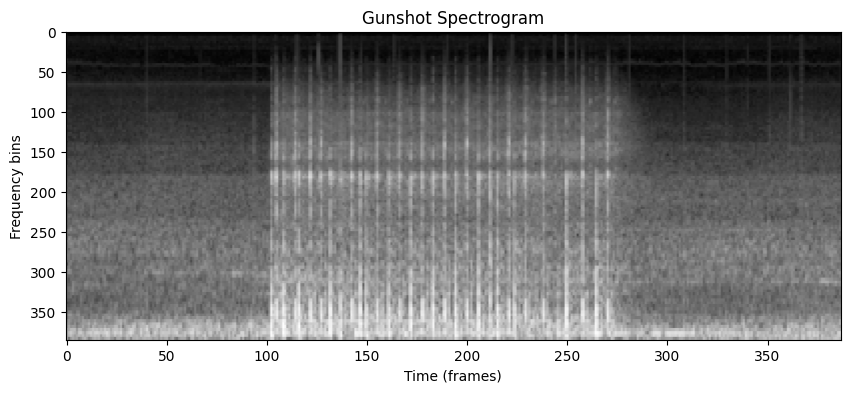

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load spectrogram image in grayscale
spectrogram_path = "/content/drive/MyDrive/ddp/spectrograms/ff842455-42f4-4c3a-8ab0-0ee2085d1c32_chan2_v0.png"
spectrogram = cv2.imread(spectrogram_path, cv2.IMREAD_GRAYSCALE)

# Display spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, cmap="gray", aspect="auto")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency bins")
plt.title("Gunshot Spectrogram")
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tqdm import tqdm

# Paths
image_dir = "/content/drive/MyDrive/ddp/spectrograms"
csv_file = "/content/drive/MyDrive/ddp/gunshot_metadata_with_firing_style.csv"

# Load labels
df = pd.read_csv(csv_file)

# Encode categorical labels (gun type)
gun_types = sorted(df["firearm"].unique())
class_to_num = {gun: i for i, gun in enumerate(gun_types)}

# Encode categorical labels (firing style)
firing_styles = sorted(df["firing_style"].unique())
firing_style_to_num = {style: i for i, style in enumerate(firing_styles)}


In [ ]:
# Initialize training data
img_size = 299  # CNN input size
X = np.zeros((len(df), img_size, img_size, 3), dtype=np.uint8)
y = np.zeros((len(df)), dtype=np.uint8)
firing_style_labels = np.zeros((len(df)), dtype=np.uint8)
num_shots_features = np.zeros((len(df), 1), dtype=np.float32)

In [ ]:
# Load images based on CSV file entries
for i in tqdm(range(len(df))):
    img_path = os.path.join(image_dir, f"{df['filename'][i]}.png")  # Ensure correct filename match
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Missing image {img_path}")
        continue  # Skip missing images

    img = cv2.resize(img, (img_size, img_size))  # Resize to CNN input shape
    X[i] = img
    y[i] = class_to_num[df["firearm"][i]]  # Convert labels to numeric class IDs
    firing_style_labels[i] = firing_style_to_num[df["firing_style"][i]]  # Convert firing style to numeric
    num_shots_features[i] = df["num_gunshots"][i]  # Use shot count as a numerical feature


100%|██████████| 2148/2148 [00:20<00:00, 103.71it/s]


In [ ]:
# Convert categorical labels to one-hot encoding
y = to_categorical(y, num_classes=len(gun_types))
firing_style_labels = to_categorical(firing_style_labels, num_classes=len(firing_styles))

In [ ]:
# Load pre-trained CNN as feature extractor
base_model = InceptionV3(include_top=False, input_shape=(img_size, img_size, 3), weights="imagenet")
inputs = Input((img_size, img_size, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Add metadata features (firing style + shot count)
firing_input = Input((len(firing_styles),))  # One-hot firing style
shot_input = Input((1,))  # Shot count (numerical)
x = Concatenate()([x, firing_input, shot_input])  # Merge all features

In [ ]:
# Final classifier layers
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(gun_types), activation="softmax")(x)  # Output layer

In [ ]:
# Compile and train model
model = Model(inputs=[inputs, firing_input, shot_input], outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit([X, firing_style_labels, num_shots_features], y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8877 - loss: 0.3274 - val_accuracy: 0.3395 - val_loss: 8.2822
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 467ms/step - accuracy: 0.9410 - loss: 0.2163 - val_accuracy: 0.2721 - val_loss: 5.2266
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - accuracy: 0.9377 - loss: 0.2023 - val_accuracy: 0.6256 - val_loss: 2.2550
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 445ms/step - accuracy: 0.9658 - loss: 0.0924 - val_accuracy: 0.3907 - val_loss: 4.3688
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - accuracy: 0.9433 - loss: 0.1795 - val_accuracy: 0.3977 - val_loss: 8.5316
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 416ms/step - accuracy: 0.9494 - loss: 0.1420 - val_accuracy: 0.5047 - val_loss: 2.5616
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 462ms/step - accuracy: 0.9706 - loss: 0.0778 - val_accuracy: 0.5977 - val_loss: 3.2109
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - accuracy: 0.9549 - loss: 0.1486 - val_accura

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test, firing_style_train, firing_style_test, num_shots_train, num_shots_test = train_test_split(
    X, y, firing_style_labels, num_shots_features, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1718, Testing samples: 430


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 622ms/step


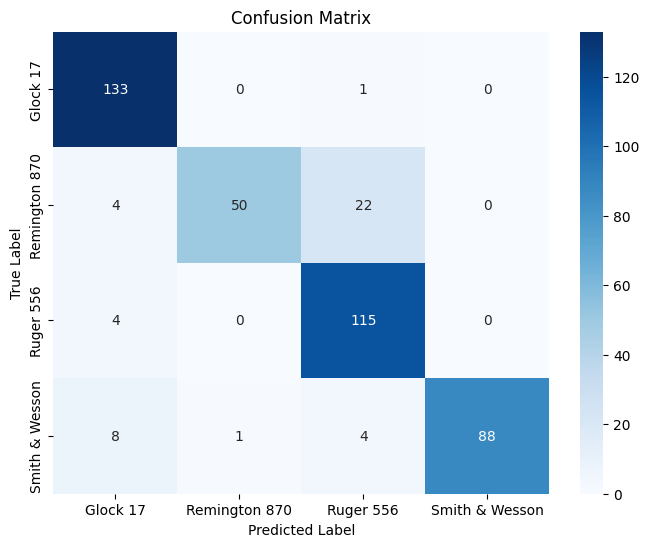

Classification Report:
                 precision    recall  f1-score   support

      Glock 17       0.89      0.99      0.94       134
 Remington 870       0.98      0.66      0.79        76
     Ruger 556       0.81      0.97      0.88       119
Smith & Wesson       1.00      0.87      0.93       101

      accuracy                           0.90       430
     macro avg       0.92      0.87      0.88       430
  weighted avg       0.91      0.90      0.89       430



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict([X_test, firing_style_test, num_shots_test])

# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_to_num.keys(), yticklabels=class_to_num.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=class_to_num.keys()))


In [ ]:
import joblib

# Assuming your trained classification model is named `clf`
joblib.dump(model, "/content/drive/MyDrive/ddp/classification_model.pkl")

print("Model saved successfully!")



Model saved successfully!
